In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pip import _internal
#_internal.main(['list'])

Package              Version   
-------------------- ----------
appdirs              1.4.3     
appnope              0.1.0     
attrs                19.3.0    
backcall             0.1.0     
beautifulsoup4       4.8.2     
bleach               3.1.0     
bs4                  0.0.1     
certifi              2019.11.28
chardet              3.0.4     
cssselect            1.1.0     
cycler               0.10.0    
Cython               0.29.16   
DateTime             4.3       
decorator            4.4.1     
defusedxml           0.6.0     
entrypoints          0.3       
fake-useragent       0.1.11    
googlefinance        0.7       
googlefinance.client 1.3.1     
idna                 2.8       
iexfinance           0.4.3     
importlib-metadata   1.5.0     
ipykernel            5.1.4     
ipynb                0.5.1     
ipython              7.12.0    
ipython-genutils     0.2.0     
jedi                 0.16.0    
Jinja2               2.11.1    
joblib               0.14.1    
json5   

You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

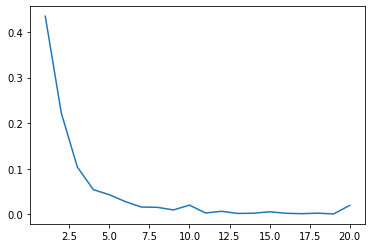

In [3]:
# load env dist
N = 20
ngram = np.load('../colorwords/data/ngram.npy')
env = ngram[0:N] / np.sum(ngram[0:N])
plt.plot(1 + np.arange(N),env)

In [5]:
# Bandit class
from numpy.random import beta
# Standard bandit
class Beta_Bandit:
    def __init__(self, n_contexts, n_arms):
        self.n_contexts = n_contexts
        self.n_arms = n_arms
        self.belief = self.ini_belief()
        
    def update_belief(self, context, arm, r):
        self.belief[context][arm]['alpha'] += r
        self.belief[context][arm]['beta'] += 1 - r
        
    def ini_belief(self):
        belief = {}
        for context in range(self.n_contexts):
            belief[context] = {}
            for arm in range(self.n_arms):
                belief[context][arm] = {'alpha' : 1.0, 'beta' : 1.0}
        return belief 
    
    def sample(self, context):
        thetas = []
        for arm in range(self.n_arms):
            thetas.append(beta(self.belief[context][arm]['alpha'], self.belief[context][arm]['beta']))
        return np.argmax(np.array(thetas))
    
    def argmax(self, context):
        thetas = []
        for arm in range(self.n_arms):
            mean = self.belief[context][arm]['alpha'] / (self.belief[context][arm]['alpha'] + self.belief[context][arm]['beta'])
            thetas.append(mean)
        return np.argmax(np.array(thetas))

    def fraction_response(self, T=1000):
        # p(w|i), "How often word w is used to describe context i
        fraction_response = {}
        for context in range(self.n_contexts):
            counts = np.zeros(self.n_arms)
            for _ in range(T):
                arm = self.sample(context=context)
                counts[arm] += 1
            fraction_response[context] = counts/T
        return fraction_response

# Reward funcs
def binary(context, guess):
    return int(context == guess)



In [10]:
# Train chain of bandits
from copy import deepcopy
def train_bandits(bandit_chain, env, N, reward_func=binary):
    regret = [0]
    avg_reward = [0]
    counter = 1
    for i in range(T):
        # Play
        arm = np.random.choice(np.arange(N), p = env)
        y = deepcopy(arm)
        context_list = []
        arm_list = []
        for bandit in bandit_chain:
            context = deepcopy(arm)
            arm = bandit.sample(context=context)
            arm_list.append(deepcopy(arm))
            context_list.append(deepcopy(context))
        # Compute reward/regret
        r = reward_func(y, arm)
        regret.append(1 - r)
        avg_reward.append(avg_reward[-1] + (r - avg_reward[-1])/counter)
        counter += 1
        # Update belief of each agent
        for k in range(len(bandit_chain)):
            context = context_list[k]
            arm = arm_list[k]
            bandit_chain[k].update_belief(context=context, arm=arm, r=r)

    regret = np.array(regret)
    total_regret = np.cumsum(regret)
    return total_regret, avg_reward

def eval_agents(bandit_chain, n_contexts, reward_func=binary):
    r = 0
    for n in range(n_contexts):
        arm = deepcopy(n)
        for bandit in bandit_chain:
            context = deepcopy(arm)
            arm = bandit.argmax(context=context)
        r += reward_func(n, arm)
    return r / n_contexts

# Batch train bandits (not very efficient). To do: enable Numba
def batch_train_bandits(bandit_chain, env, N, reward_func=binary, batch_size=10):
    regret = [0]
    avg_reward = [0]
    counter = 1
    for i in range(T):
        # Play
        batch_history = []
        # Run batch
        for j in range(batch_size):
            arm = np.random.choice(np.arange(N), p = env)
            y = deepcopy(arm)
            context_list = []
            arm_list = []
            for bandit in bandit_chain:
                context = deepcopy(arm)
                arm = bandit.sample(context=context)
                arm_list.append(deepcopy(arm))
                context_list.append(deepcopy(context))
            # Compute reward/regret
            r = reward_func(y, arm)
            batch_history.append((context_list, arm_list, r))
            
        # Update belief of each agent
        batch_average = 0
        for j in range(batch_size):
            context_list, arm_list, r = batch_history[j]
            batch_average = batch_average + (r - batch_average)/(j + 1)
            for k in range(len(bandit_chain)):
                context = context_list[k]
                arm = arm_list[k]
                bandit_chain[k].update_belief(context=context, arm=arm, r=r)
        # Log metrics     
        regret.append(1 - batch_average)
        avg_reward.append(avg_reward[-1] + (batch_average - avg_reward[-1])/counter)
        counter += 1

    # Clean-up
    regret = np.array(regret)
    total_regret = np.cumsum(regret)
    return total_regret, avg_reward

Acc: 0.85


/Users/caremil/.pyenv/versions/finance/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


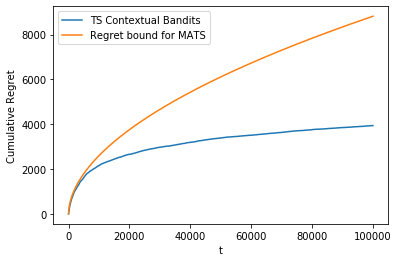

In [7]:
# 2 bandit test
# Test run
T = 100000
W = 20

sender = Beta_Bandit(N, W)
listener = Beta_Bandit(W, N)
bandit_chain = [sender, listener]
total_regret, avg_reward = train_bandits(bandit_chain, env, N)

plt.xlabel('t')
plt.ylabel('Cumulative Regret')
plt.plot(total_regret) 
x = np.linspace(0.1, T, T)
O_bound = 1/3  * np.sqrt(N ** (2) * x * np.log(N ** (2) * x))
plt.plot(x, O_bound)
plt.legend(['TS Contextual Bandits', 'Regret bound for MATS'])
r = eval_agents(bandit_chain, n_contexts=N)
print('Acc: {}'.format(r))

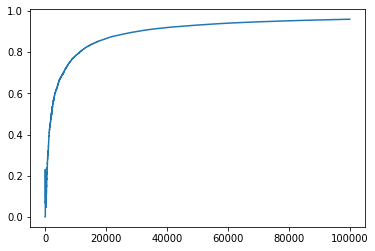

In [8]:
# Avg Reward
plt.plot(avg_reward)

Acc: 0.85


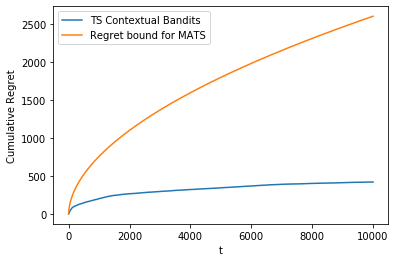

In [11]:
# 2 bandit with batch update
# Test run
T = 10000
W = 20

sender = Beta_Bandit(N, W)
listener = Beta_Bandit(W, N)
bandit_chain = [sender, listener]
total_regret, avg_reward = batch_train_bandits(bandit_chain, env, N)

plt.xlabel('t')
plt.ylabel('Cumulative Regret')
plt.plot(total_regret) 
x = np.linspace(0.1, T, T)
O_bound = 1/3  * np.sqrt(N ** (2) * x * np.log(N ** (2) * x))
plt.plot(x, O_bound)
plt.legend(['TS Contextual Bandits', 'Regret bound for MATS'])
r = eval_agents(bandit_chain, n_contexts=N)
print('Acc: {}'.format(r))

Acc: 0.65


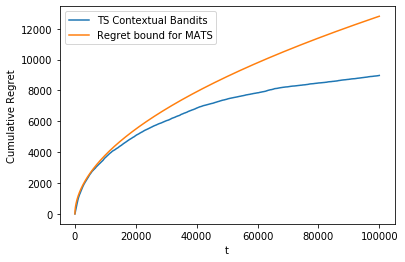

In [20]:
# K-bandits
T = 100000
W = 20
K = 3

bandit_chain = []
sender = Beta_Bandit(N, W)
bandit_chain.append(sender)

for i in range(K-2):
    bandit_chain.append(Beta_Bandit(W,W))
    
listener = Beta_Bandit(W, N)
bandit_chain.append(listener)

total_regret = train_bandits(bandit_chain, env, N)

plt.xlabel('t')
plt.ylabel('Cumulative Regret')
plt.plot(total_regret) 
x = np.linspace(0.1, T, T)
O_bound = 1/10  * np.sqrt(N ** (K) * x * np.log(N ** (K) * x))
plt.plot(x, O_bound)
plt.legend(['TS Contextual Bandits', 'Regret bound for MATS'])
r = eval_agents(bandit_chain, n_contexts=N)
print('Acc: {}'.format(r))